# REINFORCE algorithm

In [ ]:
import numpy as np
import gym
from gym import spaces

class ContinuousInventoryEnv(gym.Env):
    def __init__(self, min_inv=-10, max_inv=10, max_order=10, horizon=100, dist="uniform"):
        super().__init__()
        self.min_inv, self.max_inv = min_inv, max_inv
        self.max_order        = max_order
        self.horizon          = horizon
        self.p, self.a_cost, self.b_cost = 1.0, 1.0, 2.0
        self.sp = 2
        self.dist = dist

        # obs = [inventory level, time step]
        self.observation_space = spaces.Box(
            low=np.array([min_inv, 0], dtype=np.float32),
            high=np.array([max_inv, horizon], dtype=np.float32),
            dtype=np.float32
        )

        # raw policy output ∊ ℝ → scale to [0,max_order]
        self.action_space = spaces.Box(
            low=np.array([0.], dtype=np.float32),
            high=np.array([max_order], dtype=np.float32),
            dtype=np.float32
        )

        self.reset()

    def reset(self):
        self.s = np.random.randint(self.min_inv, self.max_inv+1)
        self.t = 0
        return np.array([self.s, self.t], dtype=np.float32)

    def step(self, action):
        # ensure scalar
        a = float(np.array(action).flatten()[0])
        # enforce bounds
        a = float(max(0, min(a, self.max_order)))
        self.t += 1

        # random continuous demand
        if self.dist == "uniform":
            w = np.random.uniform(0, 10)
        if self.dist == "geometric":
            w = np.random.geometric(0.2)
        if self.dist == "seasonal":
            if self.t <= self.horizon/2:
                w = np.random.uniform(0, 10)
            else:
                w = np.random.uniform(10, 20)

        # next inventory BEFORE clamping
        s_next = self.s + a - w

        # clamp to physical bounds
        s_next_clamped = max(self.min_inv, min(s_next, self.max_inv))
        self.s = s_next_clamped

        # compute cost on clamped inventory
        if s_next_clamped >= 0:
            cost = self.p * a + self.a_cost * s_next_clamped
        else:
            cost = self.p * a + self.b_cost * (-s_next_clamped)

        reward = -cost + w*self.sp
        done   = (self.t >= self.horizon)

        obs = np.array([self.s, self.t], dtype=np.float32)
        return obs, reward, done, {}


In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal

class GaussianPolicy(nn.Module):
    def __init__(self, state_dim, hidden_size=128):
        super().__init__()
        self.fc1     = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.mean    = nn.Linear(hidden_size, 1)
        self.log_std = nn.Parameter(torch.zeros(1))
        self.max_order = 10

    def forward(self, x):
        x  = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mu = self.mean(x)
        std = torch.exp(self.log_std).clamp(min=1e-3, max=2.0)
        return mu, std

    def get_action(self, state):
        mu, std = self(state)
        dist = Normal(mu, std)
        raw_a = dist.rsample()                   # reparam sample
        # squash to [0, max_order]
        a = torch.tanh(raw_a) * (self.max_order/2) + (self.max_order/2)
        logp = dist.log_prob(raw_a) - torch.log(
            (self.max_order/2) * (1 - torch.tanh(raw_a)**2) + 1e-6
        )
        logp = logp.sum(-1)
        return a, logp


In [46]:
import numpy as np
import matplotlib.pyplot as plt

def plot_training(all_rewards, all_log_stds, last_episode_actions, ma_window=50):
    """
    all_rewards           : list of total reward per episode
    all_log_stds          : list of policy.log_std per episode
    last_episode_actions  : list of actions taken in the final episode
    ma_window             : window size for moving average
    """
    # 1) Moving average of rewards
    rewards = np.array(all_rewards)
    if len(rewards) >= ma_window:
        mov_avg = np.convolve(rewards, np.ones(ma_window)/ma_window, mode='valid')
        ma_x = np.arange(ma_window-1, len(rewards))
    else:
        mov_avg, ma_x = None, None

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # --- Episode Reward + MA ---
    ax = axes[0]
    ax.scatter(np.arange(len(rewards)), -rewards, s=4, alpha=0.6, label='– Reward')
    if mov_avg is not None:
        ax.plot(ma_x, -mov_avg, 'r-', lw=2, label=f'{ma_window}-ep MA')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Total Reward')
    ax.set_title('Learning Curve')
    ax.legend()
    ax.grid(True)

    # --- Policy log-std ---
    ax = axes[1]
    ax.plot(all_log_stds)
    ax.set_xlabel('Episode')
    ax.set_ylabel('log-std')
    ax.set_title('Policy Uncertainty over Time')
    ax.grid(True)

    # --- Histogram of last-episode actions ---
    ax = axes[2]
    ax.hist(last_episode_actions, bins=20, density=True, alpha=0.7)
    ax.set_xlabel('Order Quantity')
    ax.set_title('Last Episode Action Distribution')
    ax.grid(True)

    plt.tight_layout()
    plt.show()


In [47]:
import numpy as np
import matplotlib.pyplot as plt

def plot_reinforce_diagnostics(all_rewards,
                                q_values,
                                state_returns,   # list of (t, G_t)
                                v_fixed_state,
                                ma_window=50):
    """
    all_rewards     : list of -sum(rewards) per episode
    q_values        : list of G_0 per episode
    state_returns   : list of (t_step, G_t) across all episodes
    v_fixed_state   : list of V(s*) estimates per episode
    ma_window       : smoothing window for learning curves
    """
    # --- Prep moving averages ---
    rewards = np.array(all_rewards)
    q_vals  = np.array(q_values)
    def moving_avg(x):
        if len(x) < ma_window:
            return np.full_like(x, np.nan)
        return np.convolve(x, np.ones(ma_window)/ma_window, mode='valid')

    rw_ma = moving_avg(rewards)
    q_ma  = moving_avg(q_vals)
    
    # --- Prep Avg Return-to-Go vs t ---
    from collections import defaultdict
    sums, counts = defaultdict(float), defaultdict(int)
    for t, G in state_returns:
        sums[t] += G
        counts[t] += 1
    t_steps = sorted(sums)
    avg_Gt  = [sums[t]/counts[t] for t in t_steps]

    # --- Plot everything in a 2×2 grid ---
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # 1) Total Reward + MA
    ax = axes[0,0]
    ax.plot(rewards, alpha=0.3, label='– Total Reward')
    ax.plot(np.arange(ma_window-1, len(rw_ma)+ma_window-1), rw_ma, 'r', lw=2,
            label=f'{ma_window}-ep MA')
    ax.set_title("Learning Curve")
    ax.set_xlabel("Episode")
    ax.set_ylabel("– Total Reward")
    ax.legend(); ax.grid(True)
    
    # 2) Q₀ and its MA
    ax = axes[0,1]
    ax.plot(q_vals, alpha=0.3, label=r'$G_0$')
    ax.plot(np.arange(ma_window-1, len(q_ma)+ma_window-1), q_ma, 'r', lw=2,
            label=f'{ma_window}-ep MA')
    ax.set_title(r"$Q(s_0,a_0)$ Convergence")
    ax.set_xlabel("Episode")
    ax.set_ylabel(r"$G_0$")
    ax.legend(); ax.grid(True)
    
    # 3) Avg Return-to-Go vs t
    ax = axes[1,0]
    ax.plot(t_steps, avg_Gt, marker='o')
    ax.set_title("Avg Return-to-Go vs Time Step")
    ax.set_xlabel("t")
    ax.set_ylabel(r"$\mathbb{E}[G_t]$")
    ax.grid(True)
    
    # 4) V(s*) over Episodes
    ax = axes[1,1]
    ax.plot(v_fixed_state, lw=1.5)
    ax.set_title(r"Value of Fixed State $s^*$")
    ax.set_xlabel("Episode")
    ax.set_ylabel(r"$V(s^*)$")
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()


In [48]:
import torch.optim as optim

def reinforce_cont(env, policy, num_episodes=500, gamma=1.0, lr=1e-3, log_interval=50):
    optimizer = optim.Adam(policy.parameters(), lr=lr)
    all_rewards, all_log_stds = [], []
    last_episode_actions = []

    for ep in range(1, num_episodes+1):
        state = env.reset()
        log_probs, rewards = [], []
        episode_actions = []
        done = False

        while not done:
            st = torch.from_numpy(state).float().unsqueeze(0)
            action_tensor, logp = policy.get_action(st)
            action = action_tensor.item()
            next_state, reward, done, _ = env.step(action)

            episode_actions.append(action)
            log_probs.append(logp)
            rewards.append(reward)
            state = next_state

        # compute and normalize returns
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns, dtype=torch.float32)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        # gradient update
        loss = torch.stack([-lp * Gt for lp, Gt in zip(log_probs, returns)]).sum()
        optimizer.zero_grad(); loss.backward(); optimizer.step()

        all_rewards.append(sum(rewards))
        all_log_stds.append(policy.log_std.item())
        last_episode_actions = episode_actions

        if ep % log_interval == 0:
            print(f"[Ep {ep}/{num_episodes}] Reward={all_rewards[-1]:.2f}, log-std={all_log_stds[-1]:.3f}")

    # final plots
    return all_rewards


In [49]:
if __name__ == "__main__":
    env = ContinuousInventoryEnv(min_inv=-20, max_inv=100, max_order=10, horizon=40)
    policy = GaussianPolicy(state_dim=env.observation_space.shape[0])
    reinforce_cont(env, policy, num_episodes=20000, gamma=0.9, lr=1e-3)



[Ep 50/20000] Reward=-3767.36, log-std=0.001
[Ep 100/20000] Reward=-776.45, log-std=-0.040
[Ep 150/20000] Reward=-890.32, log-std=-0.078
[Ep 200/20000] Reward=-1050.72, log-std=-0.123
[Ep 250/20000] Reward=-1162.72, log-std=-0.168
[Ep 300/20000] Reward=-775.62, log-std=-0.204
[Ep 350/20000] Reward=-1183.49, log-std=-0.246
[Ep 400/20000] Reward=-985.92, log-std=-0.278
[Ep 450/20000] Reward=-1260.70, log-std=-0.310
[Ep 500/20000] Reward=-754.86, log-std=-0.340
[Ep 550/20000] Reward=-675.50, log-std=-0.366
[Ep 600/20000] Reward=-476.52, log-std=-0.392
[Ep 650/20000] Reward=-525.75, log-std=-0.397
[Ep 700/20000] Reward=-26.20, log-std=-0.396
[Ep 750/20000] Reward=-367.95, log-std=-0.394
[Ep 800/20000] Reward=-15.41, log-std=-0.394
[Ep 850/20000] Reward=-228.85, log-std=-0.396
[Ep 900/20000] Reward=-331.37, log-std=-0.403
[Ep 950/20000] Reward=58.51, log-std=-0.405
[Ep 1000/20000] Reward=-581.72, log-std=-0.406
[Ep 1050/20000] Reward=-65.78, log-std=-0.422
[Ep 1100/20000] Reward=-934.27, lo

In [50]:
def reinforce_cont(env, policy, num_episodes=500, gamma=1.0, lr=1e-3, log_interval=50):
    optimizer = optim.Adam(policy.parameters(), lr=lr)

    all_rewards   = []     # –sum(rewards)
    q_values      = []     # G₀ per episode
    state_returns = []     # [(t, Gₜ)]
    v_fixed_state = []     # V(s*) estimates
    all_log_stds  = []     # policy.log_std per episode
    last_episode_actions = []

    fixed_state = None

    for ep in range(1, num_episodes+1):
        state = env.reset()
        if fixed_state is None:
            fixed_state = state.copy()

        log_probs, rewards = [], []
        ep_times, episode_actions = [], []
        done = False

        while not done:
            st_t = torch.from_numpy(state).float().unsqueeze(0)
            action_t, logp_t = policy.get_action(st_t)
            a = action_t.detach().item()

            next_state, r, done, _ = env.step(a)
            ep_times.append((env.t, r))
            log_probs.append(logp_t)
            rewards.append(r)
            episode_actions.append(a)
            state = next_state

        # returns
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns, dtype=torch.float32)

        # record metrics
        all_rewards.append(-sum(rewards))
        q_values.append(returns[0].item())
        all_log_stds.append(policy.log_std.item())
        last_episode_actions = episode_actions.copy()

        for (t_step, _), Gt in zip(ep_times, returns):
            state_returns.append((t_step, Gt.item()))

        # policy update
        norm_R = (returns - returns.mean()) / (returns.std() + 1e-8)
        loss = torch.stack([-lp * Gt for lp, Gt in zip(log_probs, norm_R)]).sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # evaluate V(s*)  
        s_star, t_star = fixed_state
        env.s, env.t = float(s_star), int(t_star)
        state = np.array([env.s, env.t], dtype=np.float32)

        G_eval, discount, done = 0.0, 1.0, False
        while not done:
            st_t = torch.from_numpy(state).float().unsqueeze(0)
            a_t, _ = policy.get_action(st_t)
            a = a_t.detach().item()
            state, r, done, _ = env.step(a)
            G_eval += discount * r
            discount *= gamma

        v_fixed_state.append(G_eval)

        if ep % log_interval == 0:
            print(f"[Ep {ep}/{num_episodes}]"
                  f" Reward={all_rewards[-1]:.1f}"
                  f" Q₀={q_values[-1]:.1f}"
                  f" V(s*)={v_fixed_state[-1]:.1f}"
                  f" log-std={all_log_stds[-1]:.3f}")

    # --- Plot diagnostics 2×2 ---
    plot_reinforce_diagnostics(all_rewards,
                                q_values,
                                state_returns,
                                v_fixed_state,
                                ma_window=50)

    # --- Plot action‐focus 1×3 ---
    plot_training(all_rewards, all_log_stds, last_episode_actions, ma_window=50)

    return all_rewards, q_values, (sorted({t for t,_ in state_returns}),
                                   [sum(G for (t,G) in state_returns if t==t_val)/
                                    sum(1 for (t,_) in state_returns if t==t_val)
                                    for t_val in sorted({t for t,_ in state_returns})]), v_fixed_state

[Ep 50/20000] Reward=624.5 Q₀=-333.9 V(s*)=-18.0 log-std=-0.014
[Ep 100/20000] Reward=847.0 Q₀=-156.7 V(s*)=-104.3 log-std=-0.017
[Ep 150/20000] Reward=827.3 Q₀=-114.9 V(s*)=-83.2 log-std=-0.047
[Ep 200/20000] Reward=832.6 Q₀=-93.1 V(s*)=-71.9 log-std=-0.089
[Ep 250/20000] Reward=751.4 Q₀=-91.2 V(s*)=-64.4 log-std=-0.128
[Ep 300/20000] Reward=1032.4 Q₀=-255.4 V(s*)=-73.9 log-std=-0.167
[Ep 350/20000] Reward=807.7 Q₀=-80.5 V(s*)=-61.3 log-std=-0.208
[Ep 400/20000] Reward=993.9 Q₀=-293.1 V(s*)=-48.9 log-std=-0.252
[Ep 450/20000] Reward=944.3 Q₀=-238.5 V(s*)=-67.3 log-std=-0.285
[Ep 500/20000] Reward=180.0 Q₀=-125.8 V(s*)=0.6 log-std=-0.314
[Ep 550/20000] Reward=370.7 Q₀=-289.8 V(s*)=1.7 log-std=-0.320
[Ep 600/20000] Reward=230.9 Q₀=3.1 V(s*)=-10.7 log-std=-0.343
[Ep 650/20000] Reward=174.1 Q₀=-186.2 V(s*)=6.0 log-std=-0.366
[Ep 700/20000] Reward=23.3 Q₀=-27.6 V(s*)=6.4 log-std=-0.368
[Ep 750/20000] Reward=-28.2 Q₀=5.8 V(s*)=0.6 log-std=-0.368
[Ep 800/20000] Reward=89.1 Q₀=-73.1 V(s*)=3.8

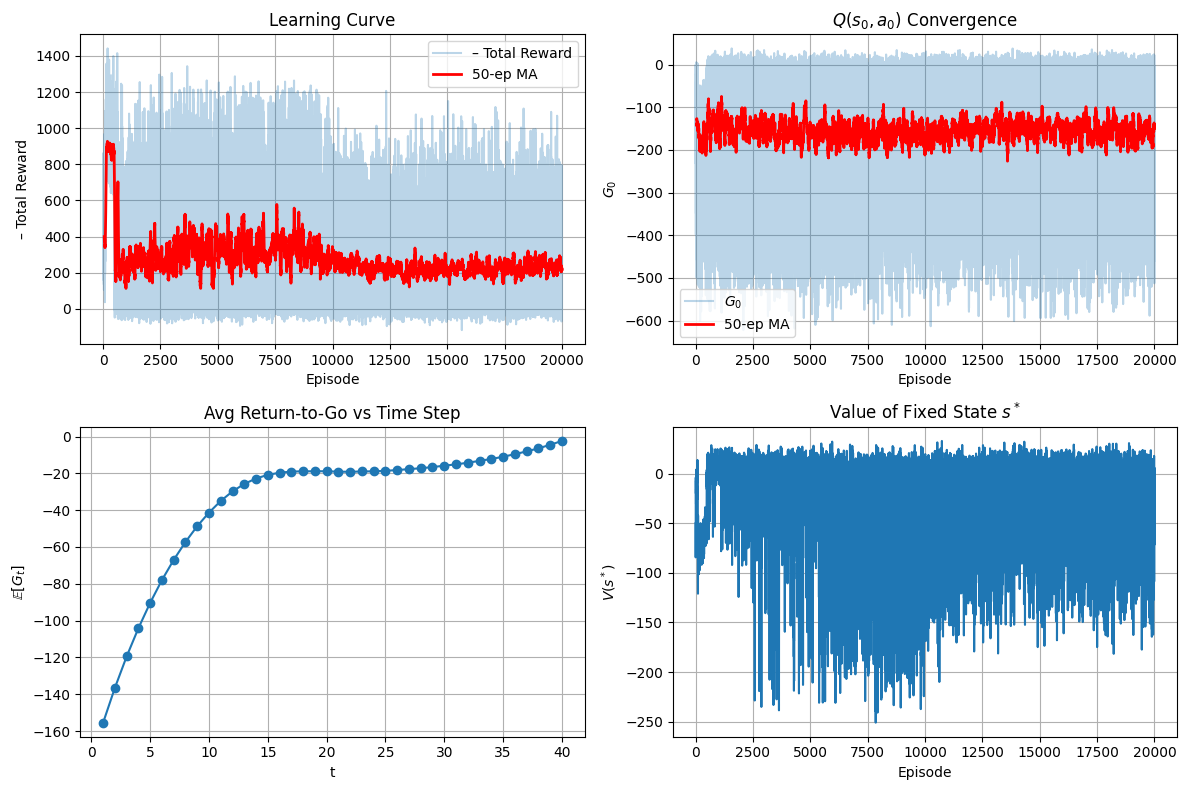

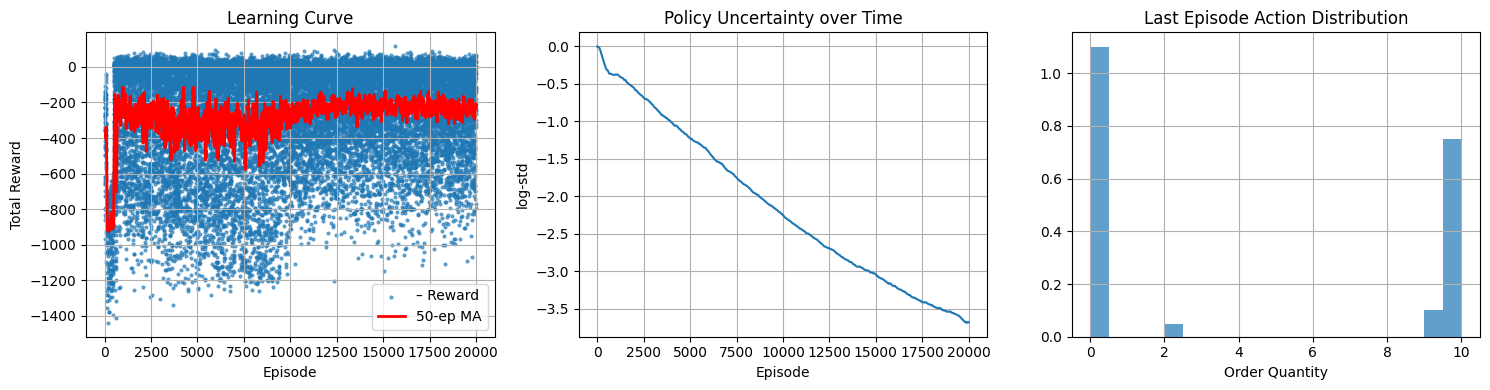

In [51]:
if __name__ == "__main__":
    env = ContinuousInventoryEnv(min_inv=-20, max_inv=100, max_order=10, horizon=40)
    policy = GaussianPolicy(state_dim=env.observation_space.shape[0])
    reinforce_cont(env, policy, num_episodes=20000, gamma=0.9, lr=1e-3)


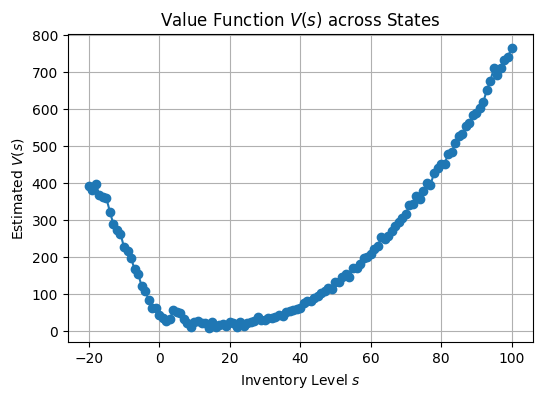

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def estimate_V_of_s(env, policy, states, num_rollouts=200, gamma=1.0):
    V = {}
    for s0 in states:
        returns = []
        for _ in range(num_rollouts):
            # reset env to exactly s0
            env.s = s0
            env.t = 0
            state = np.array([env.s, env.t], dtype=np.float32)

            G = 0; discount = 1.0
            done = False
            while not done:
                st_t = torch.from_numpy(state).float().unsqueeze(0)
                action_t, _ = policy.get_action(st_t)
                a = action_t.detach().numpy().flatten()[0]
                next_state, r, done, _ = env.step(a)
                G += discount * r
                discount *= gamma
                state = next_state
            returns.append(G)
        V[s0] = np.mean(returns)
    
    # plot
    s_vals = sorted(V.keys())
    v_vals = [-V[s] for s in s_vals]
    plt.figure(figsize=(6,4))
    plt.plot(s_vals, v_vals, marker='o')
    plt.xlabel("Inventory Level $s$")
    plt.ylabel("Estimated $V(s)$")
    plt.title("Value Function $V(s)$ across States")
    plt.grid(True)
    plt.show()
    return V

# Usage (after training):
states = range(env.min_inv, env.max_inv+1)
V_est = estimate_V_of_s(env, policy, states)


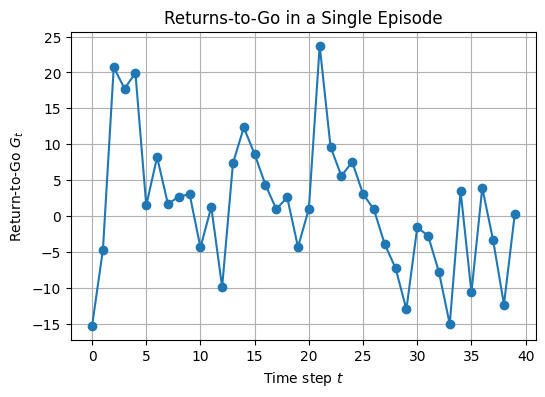

In [53]:
gamma = 0.9

# generate one trajectory
state = env.reset()
done = False
rewards = []
while not done:
    st_t = torch.from_numpy(state).float().unsqueeze(0)
    action_t, _ = policy.get_action(st_t)
    a = action_t.detach().numpy().flatten()[0]
    state, r, done, _ = env.step(a)
    rewards.append(r)

# compute G_t
G = 0
returns_to_go = []
for r in reversed(rewards):
    G = r + gamma*G
    returns_to_go.insert(0, G)

# plot
plt.figure(figsize=(6,4))
plt.plot(range(len(returns_to_go)), returns_to_go, marker='o')
plt.xlabel("Time step $t$")
plt.ylabel(r"Return-to-Go $G_t$")
plt.title("Returns-to-Go in a Single Episode")
plt.grid(True)
plt.show()


# Binomial distribution

[Ep 50/20000] Reward=1027.8 Q₀=-256.7 V(s*)=-97.2 log-std=-0.029
[Ep 100/20000] Reward=1490.2 Q₀=-555.6 V(s*)=-81.9 log-std=-0.059
[Ep 150/20000] Reward=788.7 Q₀=-80.9 V(s*)=-97.6 log-std=-0.093
[Ep 200/20000] Reward=1267.5 Q₀=-494.4 V(s*)=-77.1 log-std=-0.135
[Ep 250/20000] Reward=748.2 Q₀=-180.3 V(s*)=-75.5 log-std=-0.172
[Ep 300/20000] Reward=798.4 Q₀=-91.7 V(s*)=-78.4 log-std=-0.209
[Ep 350/20000] Reward=814.6 Q₀=-85.7 V(s*)=-76.0 log-std=-0.247
[Ep 400/20000] Reward=628.6 Q₀=-42.6 V(s*)=-87.0 log-std=-0.281
[Ep 450/20000] Reward=715.7 Q₀=-149.3 V(s*)=-52.6 log-std=-0.309
[Ep 500/20000] Reward=807.3 Q₀=-200.7 V(s*)=-65.5 log-std=-0.335
[Ep 550/20000] Reward=241.3 Q₀=-174.4 V(s*)=-5.6 log-std=-0.368
[Ep 600/20000] Reward=611.0 Q₀=-96.0 V(s*)=-50.0 log-std=-0.385
[Ep 650/20000] Reward=187.5 Q₀=-23.6 V(s*)=-17.1 log-std=-0.385
[Ep 700/20000] Reward=149.0 Q₀=-65.5 V(s*)=-4.9 log-std=-0.384
[Ep 750/20000] Reward=54.6 Q₀=-11.6 V(s*)=-44.3 log-std=-0.384
[Ep 800/20000] Reward=93.1 Q₀=-20.

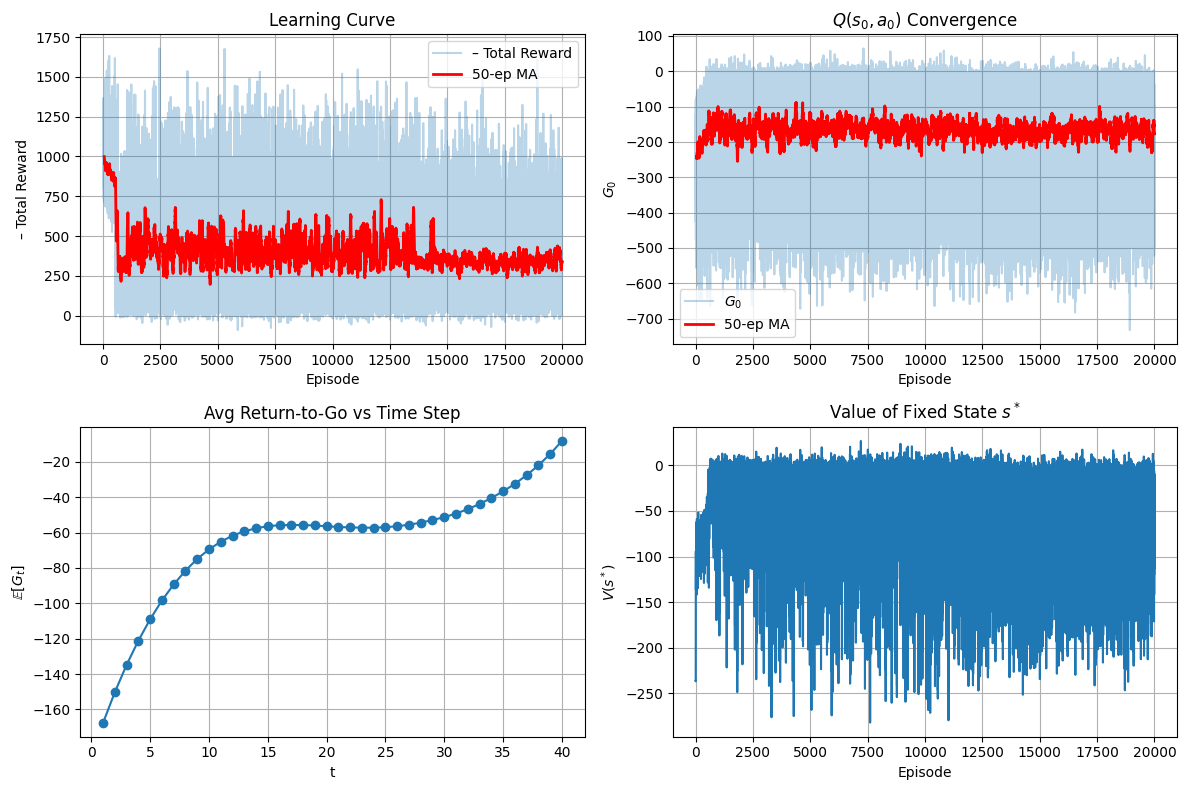

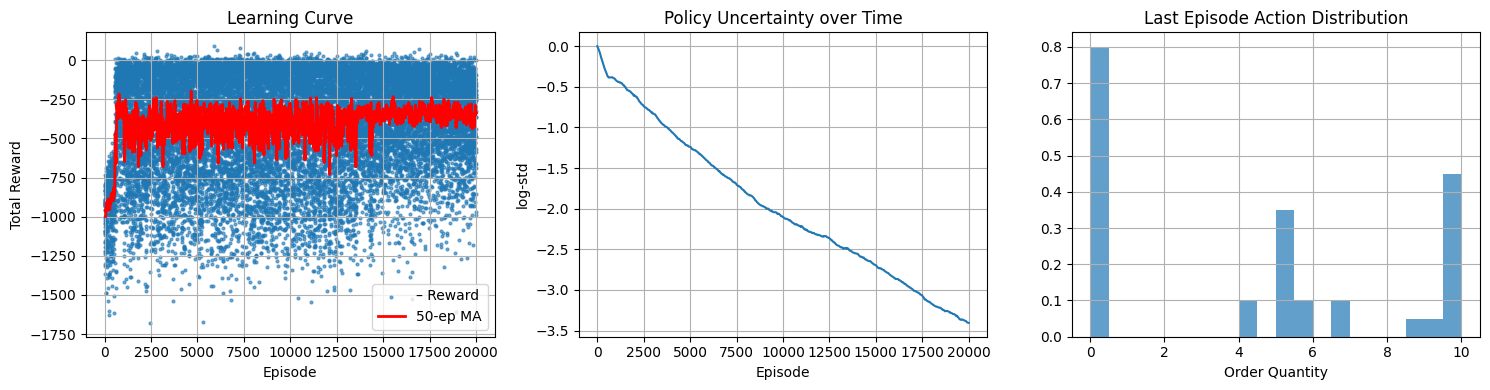

In [54]:
if __name__ == "__main__":
    env = ContinuousInventoryEnv(min_inv=-20, max_inv=100, max_order=10, horizon=40, dist="geometric")
    policy = GaussianPolicy(state_dim=env.observation_space.shape[0])
    reinforce_cont(env, policy, num_episodes=20000, gamma=0.9, lr=1e-3)


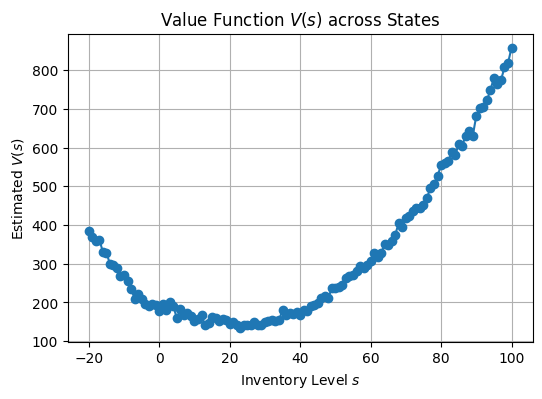

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def estimate_V_of_s(env, policy, states, num_rollouts=200, gamma=1.0):
    V = {}
    for s0 in states:
        returns = []
        for _ in range(num_rollouts):
            # reset env to exactly s0
            env.s = s0
            env.t = 0
            state = np.array([env.s, env.t], dtype=np.float32)

            G = 0; discount = 1.0
            done = False
            while not done:
                st_t = torch.from_numpy(state).float().unsqueeze(0)
                action_t, _ = policy.get_action(st_t)
                a = action_t.detach().numpy().flatten()[0]
                next_state, r, done, _ = env.step(a)
                G += discount * r
                discount *= gamma
                state = next_state
            returns.append(G)
        V[s0] = np.mean(returns)
    
    # plot
    s_vals = sorted(V.keys())
    v_vals = [-V[s] for s in s_vals]
    plt.figure(figsize=(6,4))
    plt.plot(s_vals, v_vals, marker='o')
    plt.xlabel("Inventory Level $s$")
    plt.ylabel("Estimated $V(s)$")
    plt.title("Value Function $V(s)$ across States")
    plt.grid(True)
    plt.show()
    return V

# Usage (after training):
states = range(env.min_inv, env.max_inv+1)
V_est = estimate_V_of_s(env, policy, states)


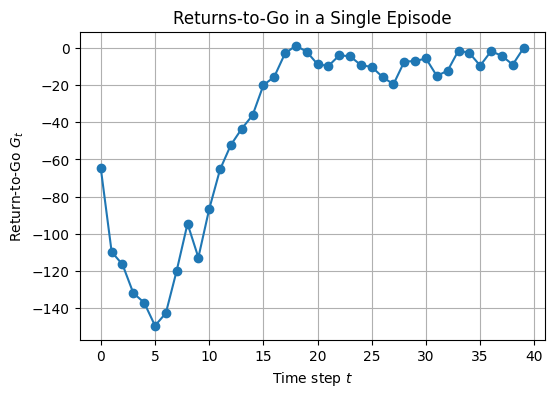

In [56]:
gamma = 0.9

# generate one trajectory
state = env.reset()
done = False
rewards = []
while not done:
    st_t = torch.from_numpy(state).float().unsqueeze(0)
    action_t, _ = policy.get_action(st_t)
    a = action_t.detach().numpy().flatten()[0]
    state, r, done, _ = env.step(a)
    rewards.append(r)

# compute G_t
G = 0
returns_to_go = []
for r in reversed(rewards):
    G = r + gamma*G
    returns_to_go.insert(0, G)

# plot
plt.figure(figsize=(6,4))
plt.plot(range(len(returns_to_go)), returns_to_go, marker='o')
plt.xlabel("Time step $t$")
plt.ylabel(r"Return-to-Go $G_t$")
plt.title("Returns-to-Go in a Single Episode")
plt.grid(True)
plt.show()


# Seasonal demand

[Ep 50/20000] Reward=601.1 Q₀=-158.6 V(s*)=-136.3 log-std=-0.025
[Ep 100/20000] Reward=572.2 Q₀=-143.0 V(s*)=-123.5 log-std=-0.062
[Ep 150/20000] Reward=1299.1 Q₀=-637.4 V(s*)=-115.5 log-std=-0.096
[Ep 200/20000] Reward=565.1 Q₀=-119.0 V(s*)=-126.5 log-std=-0.117
[Ep 250/20000] Reward=1496.2 Q₀=-329.2 V(s*)=-169.6 log-std=-0.119
[Ep 300/20000] Reward=2212.9 Q₀=-667.0 V(s*)=-218.6 log-std=-0.119
[Ep 350/20000] Reward=593.1 Q₀=-200.0 V(s*)=-81.6 log-std=-0.118
[Ep 400/20000] Reward=749.7 Q₀=-296.1 V(s*)=-125.9 log-std=-0.132
[Ep 450/20000] Reward=855.9 Q₀=-375.8 V(s*)=-153.8 log-std=-0.166
[Ep 500/20000] Reward=932.9 Q₀=-360.7 V(s*)=-156.4 log-std=-0.204
[Ep 550/20000] Reward=1908.0 Q₀=-674.0 V(s*)=-218.4 log-std=-0.234
[Ep 600/20000] Reward=761.2 Q₀=-191.3 V(s*)=-164.1 log-std=-0.279
[Ep 650/20000] Reward=1071.3 Q₀=-391.7 V(s*)=-127.6 log-std=-0.323
[Ep 700/20000] Reward=586.1 Q₀=-142.2 V(s*)=-216.5 log-std=-0.363
[Ep 750/20000] Reward=609.1 Q₀=-176.4 V(s*)=-115.3 log-std=-0.404
[Ep 800

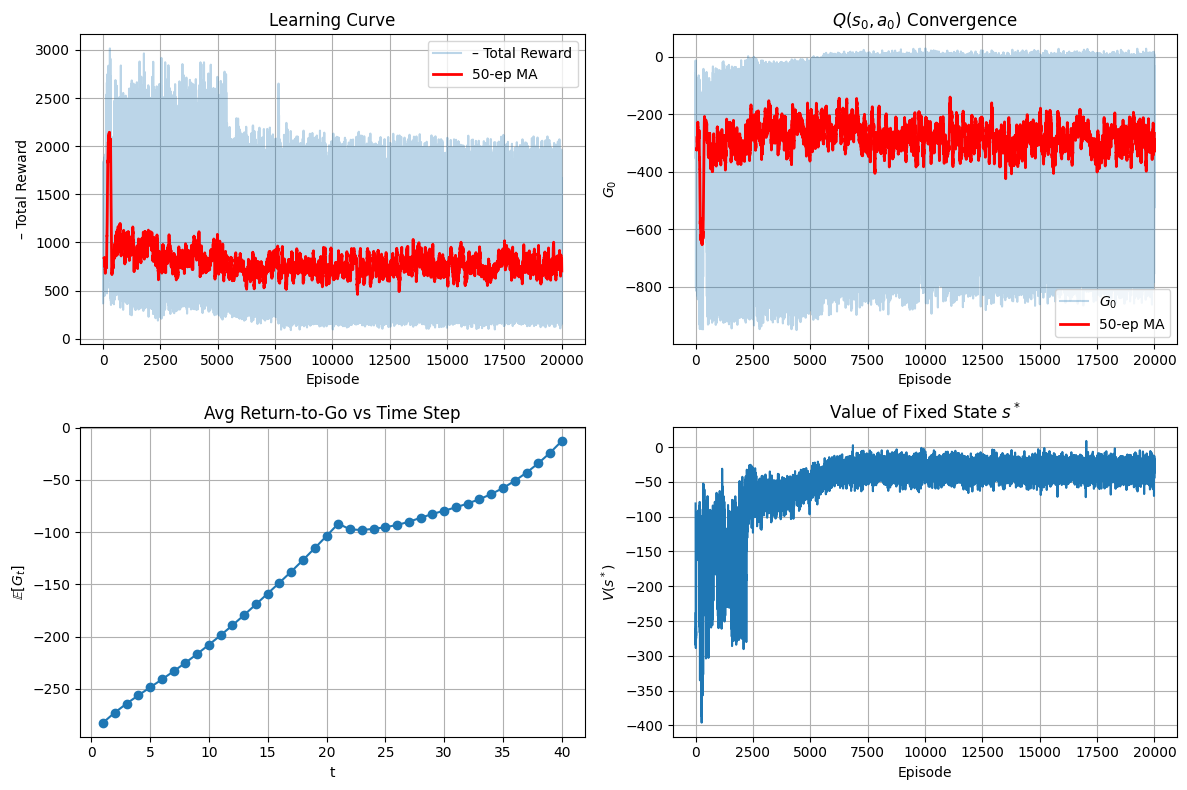

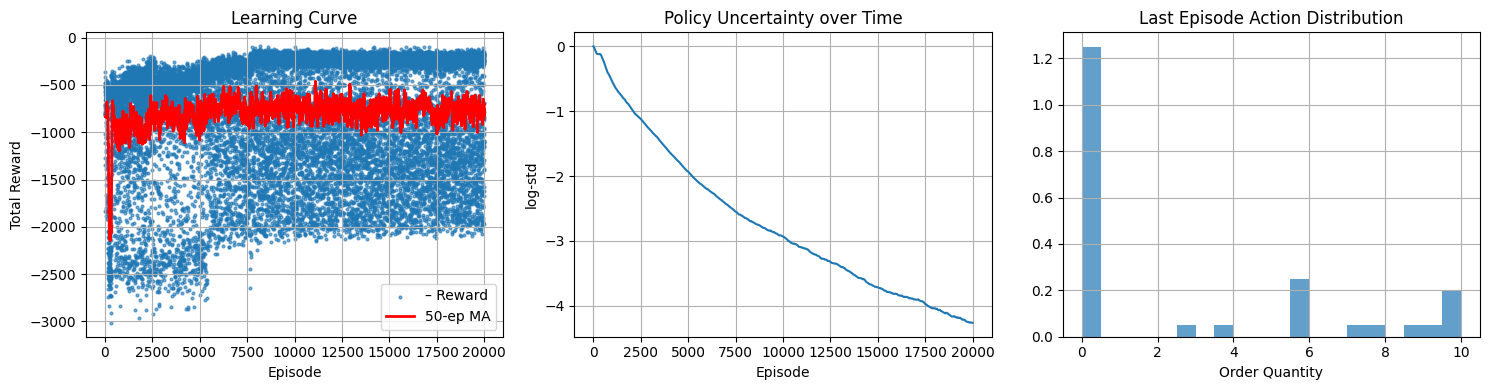

In [57]:
if __name__ == "__main__":
    env = ContinuousInventoryEnv(min_inv=-20, max_inv=100, max_order=25, horizon=40, dist="seasonal")
    policy = GaussianPolicy(state_dim=env.observation_space.shape[0])
    reinforce_cont(env, policy, num_episodes=20000, gamma=0.9, lr=1e-3)


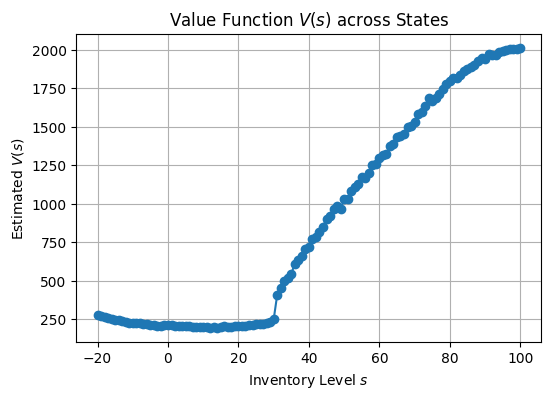

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def estimate_V_of_s(env, policy, states, num_rollouts=200, gamma=1.0):
    V = {}
    for s0 in states:
        returns = []
        for _ in range(num_rollouts):
            # reset env to exactly s0
            env.s = s0
            env.t = 0
            state = np.array([env.s, env.t], dtype=np.float32)

            G = 0; discount = 1.0
            done = False
            while not done:
                st_t = torch.from_numpy(state).float().unsqueeze(0)
                action_t, _ = policy.get_action(st_t)
                a = action_t.detach().numpy().flatten()[0]
                next_state, r, done, _ = env.step(a)
                G += discount * r
                discount *= gamma
                state = next_state
            returns.append(G)
        V[s0] = np.mean(returns)
    
    # plot
    s_vals = sorted(V.keys())
    v_vals = [-V[s] for s in s_vals]
    plt.figure(figsize=(6,4))
    plt.plot(s_vals, v_vals, marker='o')
    plt.xlabel("Inventory Level $s$")
    plt.ylabel("Estimated $V(s)$")
    plt.title("Value Function $V(s)$ across States")
    plt.grid(True)
    plt.show()
    return V

# Usage (after training):
states = range(env.min_inv, env.max_inv+1)
V_est = estimate_V_of_s(env, policy, states)


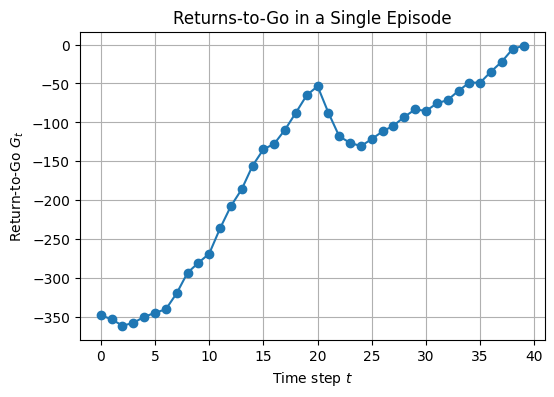

In [59]:
gamma = 0.9

# generate one trajectory
state = env.reset()
done = False
rewards = []
while not done:
    st_t = torch.from_numpy(state).float().unsqueeze(0)
    action_t, _ = policy.get_action(st_t)
    a = action_t.detach().numpy().flatten()[0]
    state, r, done, _ = env.step(a)
    rewards.append(r)

# compute G_t
G = 0
returns_to_go = []
for r in reversed(rewards):
    G = r + gamma*G
    returns_to_go.insert(0, G)

# plot
plt.figure(figsize=(6,4))
plt.plot(range(len(returns_to_go)), returns_to_go, marker='o')
plt.xlabel("Time step $t$")
plt.ylabel(r"Return-to-Go $G_t$")
plt.title("Returns-to-Go in a Single Episode")
plt.grid(True)
plt.show()


In [61]:
def plot_value_function(env, policy, time_step=0, num_points=20, gamma=0.99):
    """
    Plot the value function across the state space for a fixed time step.
    
    For 2 products: Creates a 2D heatmap of V(s) across inventory levels
    For >2 products: Creates slices of the value function varying 2 products at a time
    
    Parameters:
    - env: MultiProductInventoryEnv instance
    - policy: Trained policy
    - time_step: The fixed time step to evaluate
    - num_points: Resolution of the grid for each dimension
    - gamma: Discount factor
    """
    num_products = env.num_products
    
    # Create inventory level grid
    inv_space = np.linspace(env.min_inv, env.max_inv, num_points)
    
    if num_products == 1:
        # 1D plot for single product
        values = []
        for inv in inv_space:
            env.s = np.array([inv])
            env.t = time_step
            state = np.append(env.s, env.t).astype(np.float32)
            
            # Monte Carlo estimate of V(s)
            G, discount, done = 0.0, 1.0, False
            while not done:
                st_t = torch.from_numpy(state).float().unsqueeze(0)
                a_t, _ = policy.get_action(st_t)
                a = a_t.detach().cpu().numpy()[0]
                state, r, done, _ = env.step(a)
                G += discount * r
                discount *= gamma
            
            values.append(G)
        
        plt.figure(figsize=(10, 6))
        plt.plot(inv_space, values)
        plt.xlabel('Inventory Level')
        plt.ylabel('Value Function V(s)')
        plt.title(f'Value Function at Time Step {time_step}')
        plt.grid(True)
        plt.show()
        
    elif num_products == 2:
        # 2D heatmap for two products
        value_grid = np.zeros((num_points, num_points))
        
        for i, inv1 in enumerate(inv_space):
            for j, inv2 in enumerate(inv_space):
                env.s = np.array([inv1, inv2])
                env.t = time_step
                state = np.append(env.s, env.t).astype(np.float32)
                
                # Monte Carlo estimate of V(s)
                G, discount, done = 0.0, 1.0, False
                while not done:
                    st_t = torch.from_numpy(state).float().unsqueeze(0)
                    a_t, _ = policy.get_action(st_t)
                    a = a_t.detach().cpu().numpy()[0]
                    state, r, done, _ = env.step(a)
                    G += discount * r
                    discount *= gamma
                
                value_grid[i, j] = G
        
        plt.figure(figsize=(10, 8))
        plt.imshow(value_grid, origin='lower', extent=[env.min_inv, env.max_inv, env.min_inv, env.max_inv],
                   aspect='auto', cmap='viridis')
        plt.colorbar(label='Value Function V(s)')
        plt.xlabel('Product 1 Inventory')
        plt.ylabel('Product 2 Inventory')
        plt.title(f'Value Function at Time Step {time_step}')
        plt.grid(True)
        plt.show()
        
    else:
        # For more than 2 products, create pairwise plots
        # Show the first product pair and a diagonal slice
        
        # 1. First product pair, fixing others at median
        median_inv = (env.max_inv + env.min_inv) / 2
        value_grid = np.zeros((num_points, num_points))
        
        for i, inv1 in enumerate(inv_space):
            for j, inv2 in enumerate(inv_space):
                # Set all products to median except first two
                env.s = np.ones(num_products) * median_inv
                env.s[0], env.s[1] = inv1, inv2
                env.t = time_step
                state = np.append(env.s, env.t).astype(np.float32)
                
                # Monte Carlo estimate of V(s)
                G, discount, done = 0.0, 1.0, False
                while not done:
                    st_t = torch.from_numpy(state).float().unsqueeze(0)
                    a_t, _ = policy.get_action(st_t)
                    a = a_t.detach().cpu().numpy()[0]
                    state, r, done, _ = env.step(a)
                    G += discount * r
                    discount *= gamma
                
                value_grid[i, j] = G
        
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(value_grid, origin='lower', extent=[env.min_inv, env.max_inv, env.min_inv, env.max_inv],
                   aspect='auto', cmap='viridis')
        plt.colorbar(label='V(s)')
        plt.xlabel('Product 1 Inventory')
        plt.ylabel('Product 2 Inventory')
        plt.title(f'Value Function (Products 1-2, Others at Median)')
        plt.grid(True)
        
        # 2. Diagonal slice (all products at same inventory level)
        diag_values = []
        for inv in inv_space:
            env.s = np.ones(num_products) * inv
            env.t = time_step
            state = np.append(env.s, env.t).astype(np.float32)
            
            # Monte Carlo estimate
            G, discount, done = 0.0, 1.0, False
            while not done:
                st_t = torch.from_numpy(state).float().unsqueeze(0)
                a_t, _ = policy.get_action(st_t)
                a = a_t.detach().cpu().numpy()[0]
                state, r, done, _ = env.step(a)
                G += discount * r
                discount *= gamma
            
            diag_values.append(G)
        
        plt.subplot(1, 2, 2)
        plt.plot(inv_space, diag_values)
        plt.xlabel('All Products Inventory Level')
        plt.ylabel('Value Function V(s)')
        plt.title('Value Function (Diagonal Slice)')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()


def plot_optimal_actions(env, policy, time_step=0, num_points=20):
    """
    Plot the optimal action (order quantity) across the state space.
    
    Parameters:
    - env: MultiProductInventoryEnv instance
    - policy: Trained policy
    - time_step: The fixed time step to evaluate
    - num_points: Resolution of the grid for each dimension
    """
    num_products = env.num_products
    
    # Create inventory level grid
    inv_space = np.linspace(env.min_inv, env.max_inv, num_points)
    
    if num_products == 1:
        # 1D plot for single product
        actions = []
        for inv in inv_space:
            env.s = np.array([inv])
            env.t = time_step
            state = np.append(env.s, env.t).astype(np.float32)
            
            st_t = torch.from_numpy(state).float().unsqueeze(0)
            a_t, _ = policy.get_action(st_t)
            a = a_t.detach().cpu().numpy()[0]
            actions.append(a[0])
        
        plt.figure(figsize=(10, 6))
        plt.plot(inv_space, actions)
        plt.xlabel('Inventory Level')
        plt.ylabel('Order Quantity')
        plt.title(f'Optimal Action at Time Step {time_step}')
        plt.grid(True)
        plt.show()
        
    elif num_products == 2:
        # 2D visualization for two products
        action_grid1 = np.zeros((num_points, num_points))
        action_grid2 = np.zeros((num_points, num_points))
        
        for i, inv1 in enumerate(inv_space):
            for j, inv2 in enumerate(inv_space):
                env.s = np.array([inv1, inv2])
                env.t = time_step
                state = np.append(env.s, env.t).astype(np.float32)
                
                st_t = torch.from_numpy(state).float().unsqueeze(0)
                a_t, _ = policy.get_action(st_t)
                a = a_t.detach().cpu().numpy()[0]
                
                action_grid1[i, j] = a[0]
                action_grid2[i, j] = a[1]
        
        plt.figure(figsize=(15, 6))
        
        plt.subplot(1, 2, 1)
        plt.imshow(action_grid1, origin='lower', extent=[env.min_inv, env.max_inv, env.min_inv, env.max_inv],
                   aspect='auto', cmap='viridis')
        plt.colorbar(label='Order Quantity')
        plt.xlabel('Product 1 Inventory')
        plt.ylabel('Product 2 Inventory')
        plt.title(f'Optimal Order for Product 1 (t={time_step})')
        plt.grid(True)
        
        plt.subplot(1, 2, 2)
        plt.imshow(action_grid2, origin='lower', extent=[env.min_inv, env.max_inv, env.min_inv, env.max_inv],
                   aspect='auto', cmap='viridis')
        plt.colorbar(label='Order Quantity')
        plt.xlabel('Product 1 Inventory')
        plt.ylabel('Product 2 Inventory')
        plt.title(f'Optimal Order for Product 2 (t={time_step})')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
        
    else:
        # For more than 2 products, we'll just show the relationship between
        # inventory level and order quantity for the first 3 products
        plt.figure(figsize=(15, 5))
        
        # Create a representative set of states by varying one product's inventory
        for product_idx in range(min(3, num_products)):
            actions = []
            
            for inv in inv_space:
                # Set all products to median except current one
                median_inv = (env.max_inv + env.min_inv) / 2
                env.s = np.ones(num_products) * median_inv
                env.s[product_idx] = inv
                env.t = time_step
                state = np.append(env.s, env.t).astype(np.float32)
                
                st_t = torch.from_numpy(state).float().unsqueeze(0)
                a_t, _ = policy.get_action(st_t)
                a = a_t.detach().cpu().numpy()[0]
                
                actions.append(a[product_idx])
            
            plt.subplot(1, 3, product_idx+1)
            plt.plot(inv_space, actions)
            plt.xlabel(f'Product {product_idx+1} Inventory')
            plt.ylabel('Order Quantity')
            plt.title(f'Optimal Order (Product {product_idx+1})')
            plt.grid(True)
        
        plt.tight_layout()
        plt.show()


[Ep 50/3000] Reward=-184.8 Q₀=26.9 V(s*)=36.4 avg_log-std=-0.018
[Ep 100/3000] Reward=532.4 Q₀=365.1 V(s*)=217.7 avg_log-std=-0.040
[Ep 150/3000] Reward=208.1 Q₀=253.6 V(s*)=280.0 avg_log-std=-0.089
[Ep 200/3000] Reward=260.2 Q₀=273.9 V(s*)=375.4 avg_log-std=-0.127
[Ep 250/3000] Reward=730.6 Q₀=524.0 V(s*)=510.1 avg_log-std=-0.168
[Ep 300/3000] Reward=327.4 Q₀=285.3 V(s*)=351.2 avg_log-std=-0.222
[Ep 350/3000] Reward=456.2 Q₀=346.8 V(s*)=380.6 avg_log-std=-0.274
[Ep 400/3000] Reward=387.2 Q₀=308.3 V(s*)=310.1 avg_log-std=-0.324
[Ep 450/3000] Reward=235.8 Q₀=271.6 V(s*)=314.9 avg_log-std=-0.368
[Ep 500/3000] Reward=409.1 Q₀=259.5 V(s*)=167.5 avg_log-std=-0.400
[Ep 550/3000] Reward=512.6 Q₀=421.7 V(s*)=392.9 avg_log-std=-0.413
[Ep 600/3000] Reward=330.7 Q₀=289.1 V(s*)=262.4 avg_log-std=-0.446
[Ep 650/3000] Reward=663.4 Q₀=484.8 V(s*)=376.5 avg_log-std=-0.492
[Ep 700/3000] Reward=357.1 Q₀=287.7 V(s*)=398.1 avg_log-std=-0.535
[Ep 750/3000] Reward=277.8 Q₀=273.0 V(s*)=288.4 avg_log-std=-0.5

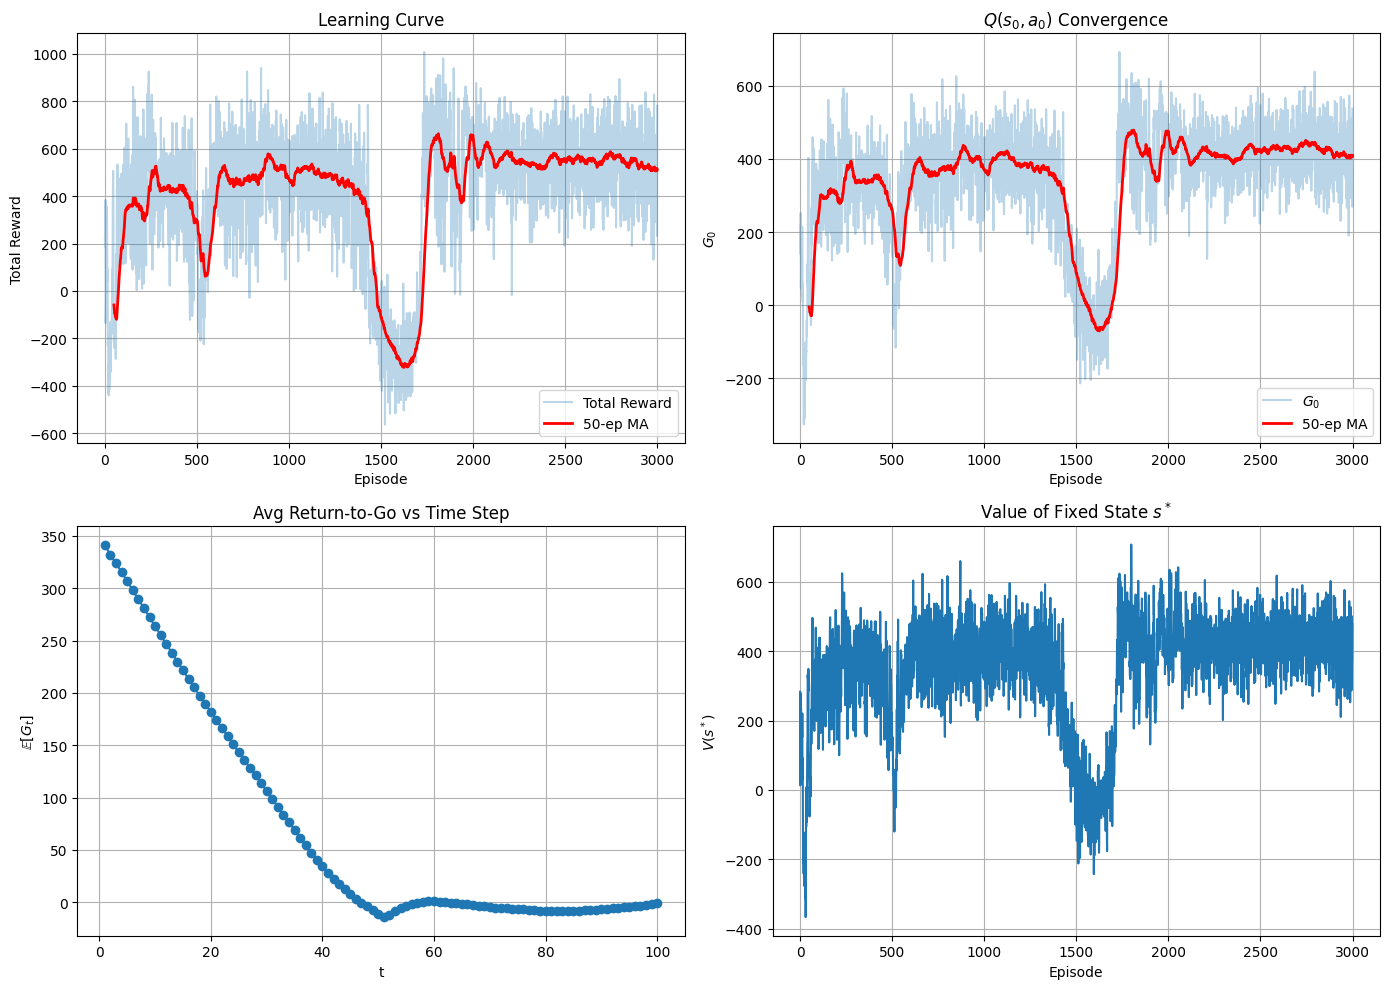

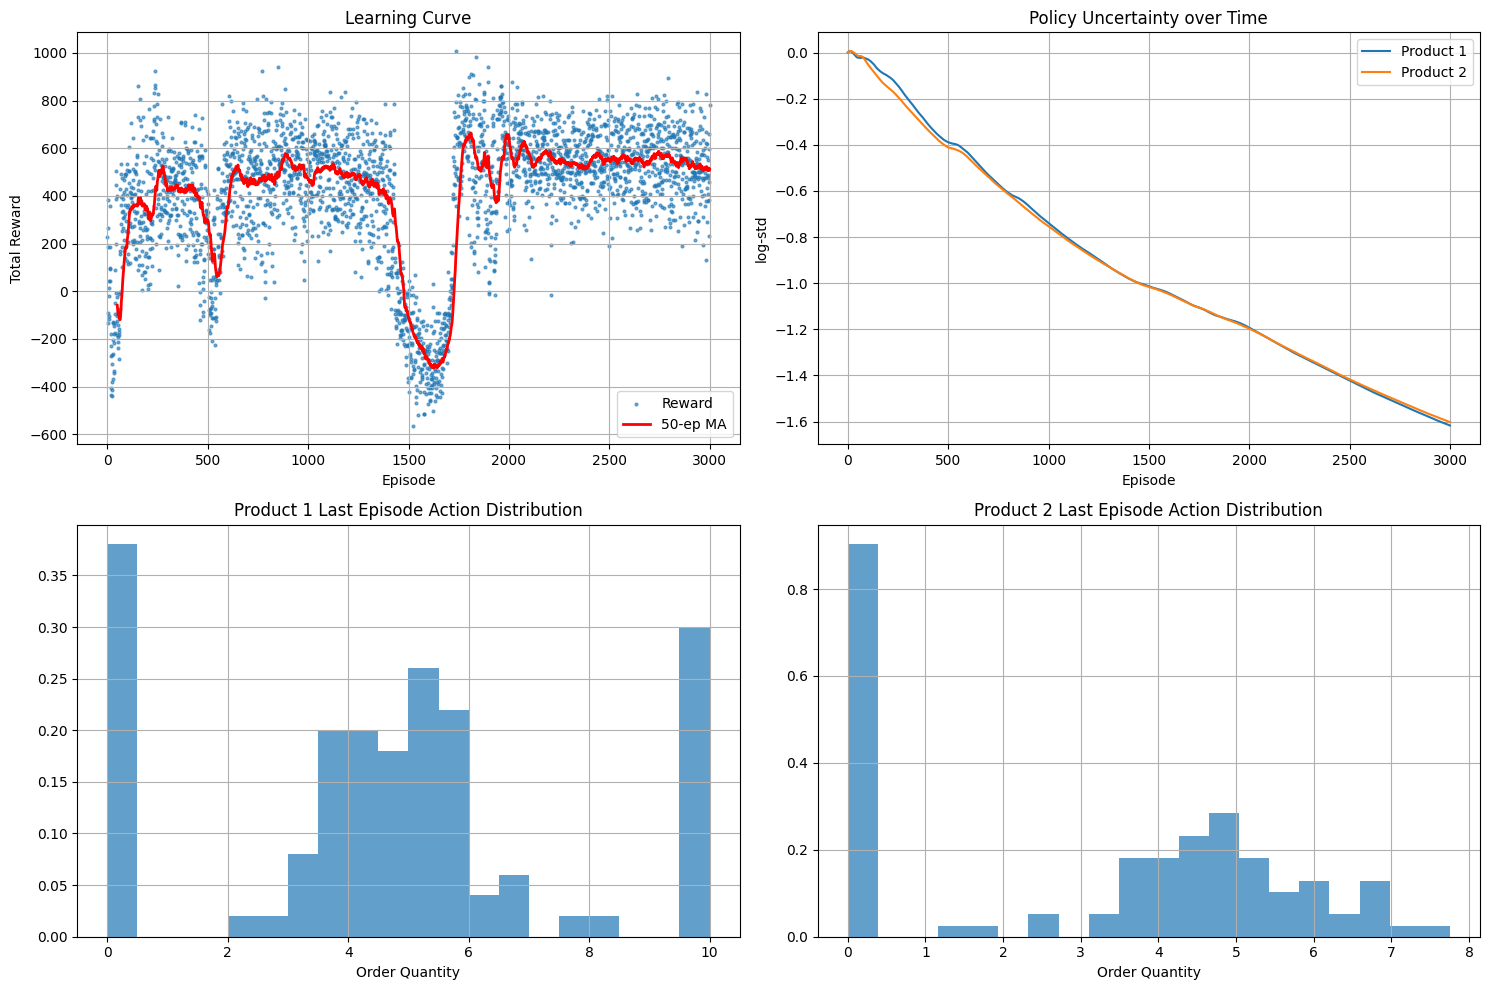

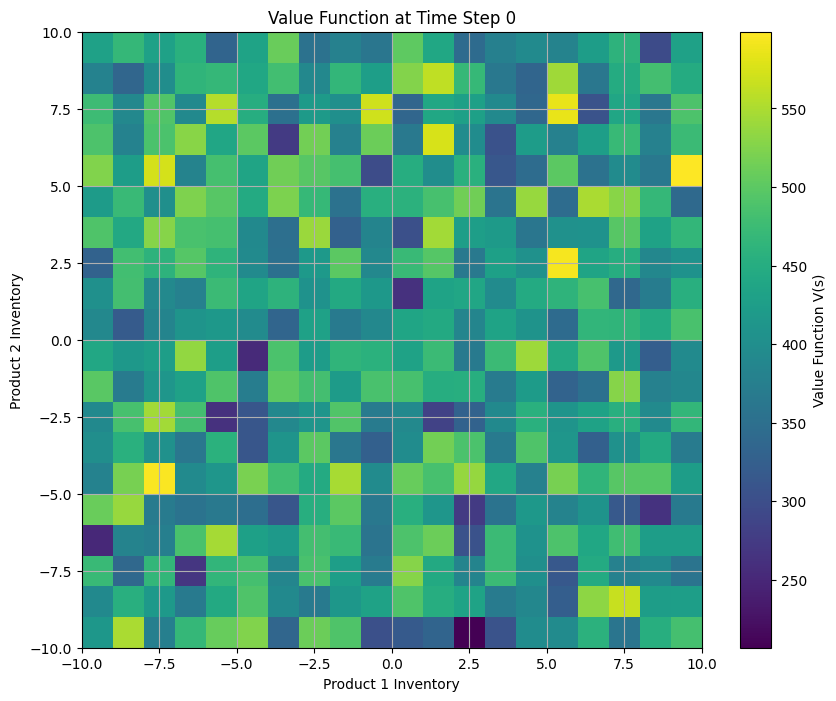


Generating optimal action visualizations...


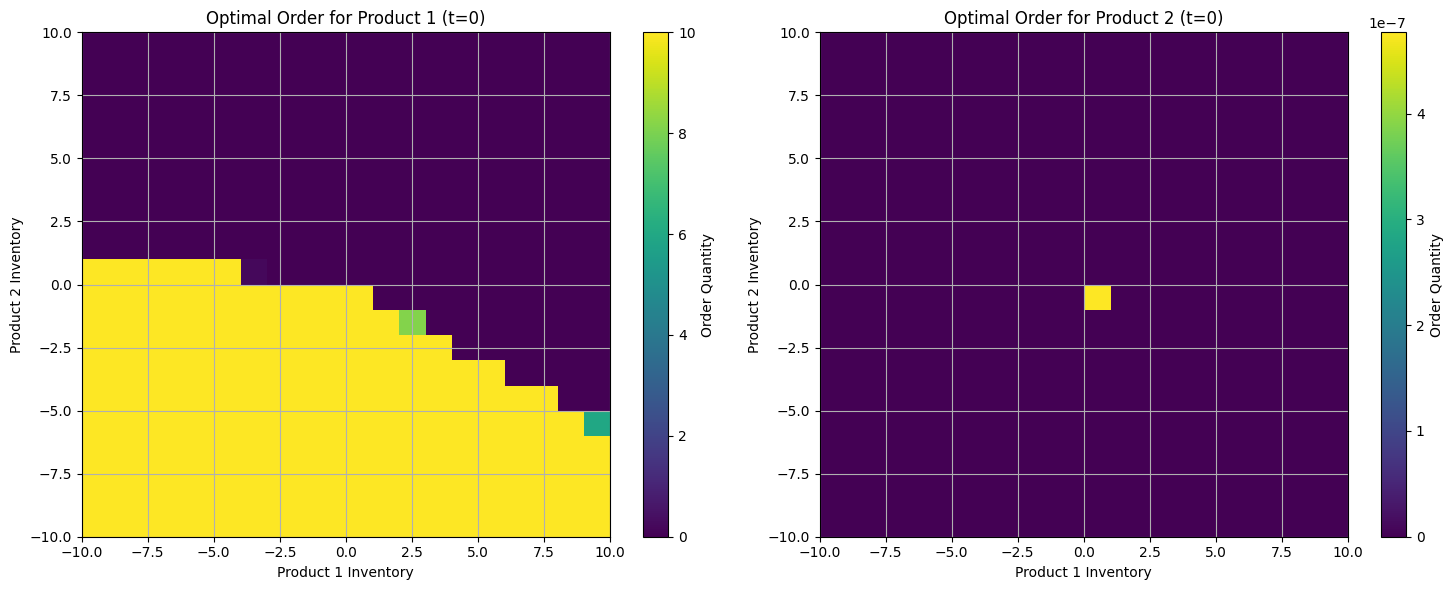

In [62]:
class MultiProductInventoryEnv(gym.Env):
    def __init__(self, num_products=2, min_inv=-10, max_inv=10, max_order=10, horizon=100, dist="uniform"):
        super().__init__()
        self.num_products = num_products
        self.min_inv, self.max_inv = min_inv, max_inv
        self.max_order = max_order
        self.horizon = horizon
        
        # Parameters for each product: [price, holding cost, backorder cost, selling price]
        # Default: each product has slightly different parameters
        self.product_params = []
        for i in range(num_products):
            self.product_params.append({
                'p': 1.0 + 0.1*i,        # purchase price
                'a_cost': 1.0 + 0.05*i,  # holding cost
                'b_cost': 2.0 + 0.1*i,   # backorder cost
                'sp': 2.0 + 0.2*i        # selling price
            })
        
        self.dist = dist
        
        # obs = [inventory levels for all products, time step]
        # shape: (num_products + 1,)
        self.observation_space = spaces.Box(
            low=np.array([min_inv] * num_products + [0], dtype=np.float32),
            high=np.array([max_inv] * num_products + [horizon], dtype=np.float32),
            dtype=np.float32
        )
        
        # action space = order quantity for each product
        # shape: (num_products,)
        self.action_space = spaces.Box(
            low=np.zeros(num_products, dtype=np.float32),
            high=np.ones(num_products, dtype=np.float32) * max_order,
            dtype=np.float32
        )
        
        self.reset()
    
    def reset(self):
        # Initialize inventory levels for all products
        self.s = np.random.randint(self.min_inv, self.max_inv+1, size=self.num_products)
        self.t = 0
        return np.append(self.s, self.t).astype(np.float32)
    
    def step(self, action):
        # Enforce action bounds
        action = np.clip(action, 0, self.max_order)
        self.t += 1
        
        # Generate demand for each product
        demands = np.zeros(self.num_products)
        
        for i in range(self.num_products):
            if self.dist == "uniform":
                demands[i] = np.random.uniform(0, 10)
            elif self.dist == "geometric":
                demands[i] = np.random.geometric(0.2)
            elif self.dist == "seasonal":
                if self.t <= self.horizon/2:
                    if i % 2 == 0:
                        demands[i] = np.random.uniform(0, 10)
                    if i % 2 == 1:
                        demands[i] = np.random.uniform(10, 20)
                else:
                    if i % 2 == 0:
                        demands[i] = np.random.uniform(10, 20)
                    else:
                        demands[i] = np.random.uniform(0, 10)
        
        # Update inventory levels for all products
        s_next = self.s + action - demands
        
        # Clamp inventory levels
        s_next_clamped = np.clip(s_next, self.min_inv, self.max_inv)
        self.s = s_next_clamped
        
        # Compute cost and reward for each product
        total_cost = 0
        total_revenue = 0
        
        for i in range(self.num_products):
            params = self.product_params[i]
            
            # Purchase cost
            purchase_cost = params['p'] * action[i]
            
            # Holding or backorder cost
            if s_next_clamped[i] >= 0:
                inventory_cost = params['a_cost'] * s_next_clamped[i]
            else:
                inventory_cost = params['b_cost'] * (-s_next_clamped[i])
            
            # Revenue from sales
            revenue = demands[i] * params['sp']
            
            total_cost += purchase_cost + inventory_cost
            total_revenue += revenue
        
        reward = total_revenue - total_cost
        done = (self.t >= self.horizon)
        
        obs = np.append(self.s, self.t).astype(np.float32)
        return obs, reward, done, {'demands': demands, 'actions': action}


class MultiProductGaussianPolicy(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.mean = nn.Linear(hidden_size, action_dim)
        
        # Initialize separate log_std for each product
        self.log_std = nn.Parameter(torch.zeros(action_dim))
        self.max_order = 10
        self.action_dim = action_dim
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mu = self.mean(x)
        std = torch.exp(self.log_std).clamp(min=1e-3, max=2.0)
        return mu, std
    
    def get_action(self, state):
        mu, std = self(state)
        dist = Normal(mu, std)
        raw_a = dist.rsample()  # reparameterization sample
        
        # Squash actions to [0, max_order]
        a = torch.tanh(raw_a) * (self.max_order/2) + (self.max_order/2)
        
        # Calculate log probs with adjustment for tanh squashing
        logp = dist.log_prob(raw_a) - torch.log(
            (self.max_order/2) * (1 - torch.tanh(raw_a)**2) + 1e-6
        )
        logp = logp.sum(-1)
        
        return a, logp


def plot_multi_product_training(all_rewards, all_log_stds, last_episode_actions, ma_window=50):
    """
    Plot training metrics for multi-product inventory management
    
    Parameters:
    - all_rewards: list of total rewards per episode
    - all_log_stds: numpy array of shape (num_episodes, num_products) containing log_std values
    - last_episode_actions: numpy array of shape (episode_length, num_products)
    - ma_window: window size for moving average
    """
    num_products = all_log_stds.shape[1]
    
    # Calculate moving average of rewards
    rewards = np.array(all_rewards)
    if len(rewards) >= ma_window:
        mov_avg = np.convolve(rewards, np.ones(ma_window)/ma_window, mode='valid')
        ma_x = np.arange(ma_window-1, len(rewards))
    else:
        mov_avg, ma_x = None, None
    
    # Create plot with 2 rows: first row for rewards, second row for actions
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Episode Reward + MA
    ax = axes[0, 0]
    ax.scatter(np.arange(len(rewards)), rewards, s=4, alpha=0.6, label='Reward')
    if mov_avg is not None:
        ax.plot(ma_x, mov_avg, 'r-', lw=2, label=f'{ma_window}-ep MA')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Total Reward')
    ax.set_title('Learning Curve')
    ax.legend()
    ax.grid(True)
    
    # Policy log-std for each product
    ax = axes[0, 1]
    for i in range(num_products):
        ax.plot(all_log_stds[:, i], label=f'Product {i+1}')
    ax.set_xlabel('Episode')
    ax.set_ylabel('log-std')
    ax.set_title('Policy Uncertainty over Time')
    ax.legend()
    ax.grid(True)
    
    # Histogram of last-episode actions for each product
    for i in range(min(num_products, 2)):
        ax = axes[1, i]
        ax.hist(last_episode_actions[:, i], bins=20, density=True, alpha=0.7)
        ax.set_xlabel('Order Quantity')
        ax.set_title(f'Product {i+1} Last Episode Action Distribution')
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()


def plot_multi_product_diagnostics(all_rewards, q_values, state_returns, v_fixed_state, ma_window=50):
    """
    Plot diagnostics for multi-product REINFORCE
    
    Parameters:
    - all_rewards: list of rewards per episode
    - q_values: list of G_0 per episode
    - state_returns: list of (t, G_t) across all episodes
    - v_fixed_state: list of V(s*) estimates per episode
    - ma_window: smoothing window for learning curves
    """
    # Prepare moving averages
    rewards = np.array(all_rewards)
    q_vals = np.array(q_values)
    
    def moving_avg(x):
        if len(x) < ma_window:
            return np.full_like(x, np.nan)
        return np.convolve(x, np.ones(ma_window)/ma_window, mode='valid')
    
    rw_ma = moving_avg(rewards)
    q_ma = moving_avg(q_vals)
    
    # Prepare Avg Return-to-Go vs t
    from collections import defaultdict
    sums, counts = defaultdict(float), defaultdict(int)
    for t, G in state_returns:
        sums[t] += G
        counts[t] += 1
    t_steps = sorted(sums)
    avg_Gt = [sums[t]/counts[t] for t in t_steps]
    
    # Plot everything in a 2×2 grid
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1) Total Reward + MA
    ax = axes[0, 0]
    ax.plot(rewards, alpha=0.3, label='Total Reward')
    ax.plot(np.arange(ma_window-1, len(rw_ma)+ma_window-1), rw_ma, 'r', lw=2,
            label=f'{ma_window}-ep MA')
    ax.set_title("Learning Curve")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Total Reward")
    ax.legend(); ax.grid(True)
    
    # 2) Q₀ and its MA
    ax = axes[0, 1]
    ax.plot(q_vals, alpha=0.3, label=r'$G_0$')
    ax.plot(np.arange(ma_window-1, len(q_ma)+ma_window-1), q_ma, 'r', lw=2,
            label=f'{ma_window}-ep MA')
    ax.set_title(r"$Q(s_0,a_0)$ Convergence")
    ax.set_xlabel("Episode")
    ax.set_ylabel(r"$G_0$")
    ax.legend(); ax.grid(True)
    
    # 3) Avg Return-to-Go vs t
    ax = axes[1, 0]
    ax.plot(t_steps, avg_Gt, marker='o')
    ax.set_title("Avg Return-to-Go vs Time Step")
    ax.set_xlabel("t")
    ax.set_ylabel(r"$\mathbb{E}[G_t]$")
    ax.grid(True)
    
    # 4) V(s*) over Episodes
    ax = axes[1, 1]
    ax.plot(v_fixed_state, lw=1.5)
    ax.set_title(r"Value of Fixed State $s^*$")
    ax.set_xlabel("Episode")
    ax.set_ylabel(r"$V(s^*)$")
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()


def reinforce_multi_product(env, policy, num_episodes=500, gamma=1.0, lr=1e-3, log_interval=50):
    """REINFORCE algorithm for multi-product inventory management"""
    optimizer = optim.Adam(policy.parameters(), lr=lr)
    
    num_products = env.num_products
    
    all_rewards = []       # Total reward per episode
    q_values = []          # G₀ per episode
    state_returns = []     # [(t, Gₜ)]
    v_fixed_state = []     # V(s*) estimates
    all_log_stds = []      # Policy log_std per episode (for each product)
    last_episode_actions = None
    
    fixed_state = None
    
    for ep in range(1, num_episodes+1):
        state = env.reset()
        if fixed_state is None:
            fixed_state = state.copy()
        
        log_probs, rewards = [], []
        ep_times = []
        episode_actions = []
        done = False
        
        while not done:
            st_t = torch.from_numpy(state).float().unsqueeze(0)
            action_t, logp_t = policy.get_action(st_t)
            
            # Convert to numpy array for environment
            a = action_t.detach().cpu().numpy()[0]
            
            next_state, r, done, _ = env.step(a)
            ep_times.append((env.t, r))
            log_probs.append(logp_t)
            rewards.append(r)
            episode_actions.append(a)
            state = next_state
        
        episode_actions = np.array(episode_actions)
        
        # Calculate returns
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns, dtype=torch.float32)
        
        # Record metrics
        all_rewards.append(sum(rewards))
        q_values.append(returns[0].item())
        avg_log_std = np.mean(policy.log_std.detach().cpu().numpy())
        all_log_stds.append(policy.log_std.detach().cpu().numpy().copy())
        
        # Store last episode actions
        last_episode_actions = episode_actions
        
        for (t_step, r), Gt in zip(ep_times, returns):
            state_returns.append((t_step, Gt.item()))
        
        # Policy update
        norm_R = (returns - returns.mean()) / (returns.std() + 1e-8)
        loss = torch.stack([-lp * Gt for lp, Gt in zip(log_probs, norm_R)]).sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Evaluate V(s*)
        fixed_s = fixed_state.copy()
        env.s = fixed_s[:-1].copy()  # All except the time component
        env.t = int(fixed_s[-1])
        state = np.append(env.s, env.t).astype(np.float32)
        
        G_eval, discount, done = 0.0, 1.0, False
        while not done:
            st_t = torch.from_numpy(state).float().unsqueeze(0)
            a_t, _ = policy.get_action(st_t)
            a = a_t.detach().cpu().numpy()[0]
            state, r, done, _ = env.step(a)
            G_eval += discount * r
            discount *= gamma
        
        v_fixed_state.append(G_eval)
        
        if ep % log_interval == 0:
            avg_log_std = np.mean(policy.log_std.detach().cpu().numpy())
            print(f"[Ep {ep}/{num_episodes}]"
                  f" Reward={all_rewards[-1]:.1f}"
                  f" Q₀={q_values[-1]:.1f}"
                  f" V(s*)={v_fixed_state[-1]:.1f}"
                  f" avg_log-std={avg_log_std:.3f}")
    
    # Convert log_stds to numpy array for plotting
    all_log_stds = np.array(all_log_stds)
    
    # Plot diagnostics
    plot_multi_product_diagnostics(all_rewards,
                                   q_values,
                                   state_returns,
                                   v_fixed_state,
                                   ma_window=50)
    
    # Plot action-focus
    plot_multi_product_training(all_rewards, all_log_stds, last_episode_actions, ma_window=50)

    plot_value_function(env, policy, time_step=0, num_points=20, gamma=gamma)
    
    # Plot optimal actions
    print("\nGenerating optimal action visualizations...")
    plot_optimal_actions(env, policy, time_step=0, num_points=20)
    
    # Return training data
    t_steps = sorted({t for t, _ in state_returns})
    avg_returns = [sum(G for (t, G) in state_returns if t == t_val) /
                  sum(1 for (t, _) in state_returns if t == t_val)
                  for t_val in t_steps]
    
    return all_rewards, q_values, (t_steps, avg_returns), v_fixed_state


# Example usage:
if __name__ == "__main__":
    # Create environment with 2 products
    env = MultiProductInventoryEnv(num_products=2, 
                                   min_inv=-10, 
                                   max_inv=10, 
                                   max_order=10, 
                                   horizon=100, 
                                   dist="seasonal")
    
    # Create policy
    state_dim = env.observation_space.shape[0]  # num_products + 1 (for time)
    action_dim = env.action_space.shape[0]      # num_products
    policy = MultiProductGaussianPolicy(state_dim, action_dim, hidden_size=128)
    
    # Train
    reinforce_multi_product(env, policy, num_episodes=3000, gamma=0.99, lr=1e-3, log_interval=50)